In [1]:
import os
import numpy as np
import pandas as pd
from urbansim.utils import misc
import matplotlib.pyplot as plt
from scipy import optimize as opt
from urbansim.models import MNLDiscreteChoiceModel

%matplotlib inline
plt.style.use('ggplot')
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Load model objects and saved explanatory variables

In [2]:
store = pd.HDFStore('hlcm_expvars.h5')

buildings = store.buildings
hh = store.households

In [3]:
model_coeffs = {}
for model_config in os.listdir('configs/regional/hlcm'):
    submodel = MNLDiscreteChoiceModel.from_yaml(
                    str_or_buffer='configs/regional/hlcm/' + model_config)
    submodel_coeffs = submodel.fit_parameters.Coefficient
    quartile_id = int(model_config.split('.')[0][-1])
    model_coeffs[quartile_id] = submodel_coeffs

In [4]:
buildings['children:nodes_walk_percent_hh_with_children'] = .59 * buildings.nodes_walk_percent_hh_with_children
buildings['hhsize_lt_3:mean_zonal_hhsize'] = .61 * buildings.mean_zonal_hhsize
buildings['is_race1:nodes_walk_percent_race1'] = .72 * buildings.nodes_walk_percent_race1
buildings['is_race2:nodes_walk_percent_race2'] = .21 * buildings.nodes_walk_percent_race2
buildings['is_race4:nodes_walk_percent_race4'] = .05 * buildings.nodes_walk_percent_race4
buildings['is_young:zones_empden'] = .17 * buildings.zones_empden
buildings['ln_income:nodes_walk_ln_popden'] = 11.5 * buildings.nodes_walk_ln_popden
buildings['ln_income:sqft_price_res'] = 11.5 * buildings.sqft_price_res
buildings['has_children:nodes_drv_elem_school_perf'] = .41 * buildings.nodes_drv_elem_school_perf

In [5]:
expvars = []
for submodel_id in model_coeffs.keys():
    expvars.extend(model_coeffs[submodel_id].index)
    
expvars = list(set(expvars))

buildings = buildings[expvars + ['vacant_residential_units', 'mode_income_quartile']]

### Prep data

In [6]:

quartile_change

1    71921
2    70719
3    43676
4    25944
dtype: int64

In [7]:
quartile_change = pd.Series({1:71921, 2:70719, 3:43676, 4:25944})

building_cols = buildings.columns.values

submodel_ids = [1, 2, 3, 4]

large_area_ids = [3, 5, 93, 99, 115, 125, 147, 161]

quartile_changes = []
for submodel_id in submodel_ids:
    quartile_changes.append(quartile_change.loc[submodel_id])
    
x = np.transpose(buildings.as_matrix())

quartile_changes = np.array(quartile_changes).reshape((len(quartile_changes), 1))
vacant_spaces = buildings.vacant_residential_units.values

def get_submodel_coeffs():
    w = []

    for submodel_id in submodel_ids:
        coeffs = model_coeffs[submodel_id]

        coeff_vals = pd.Series(0.0, index=building_cols)
        coeff_vals.loc[coeffs.index] = coeffs.values
        w.append(coeff_vals.values)

    return np.array(w)

## Summed probabilities by zonal mode income quartile

In [8]:
def calculate_proba(w, x):
    utilities = np.dot(w, x)
    exp_utility = np.exp(utilities)

    sum_expu_across_submodels = exp_utility.sum(axis=1, keepdims=True)
    proba = exp_utility / sum_expu_across_submodels

    return proba

In [9]:
# Get ELCM coefficients for large area 3
w = get_submodel_coeffs()

# Calculate probabilities
proba = np.transpose(calculate_proba(w, x))
proba_df = pd.DataFrame(proba, columns = submodel_ids)

# Sum probabilities by building type
proba_df['mode_income_quartile'] = buildings.mode_income_quartile.values
summed_proba_mode_income = proba_df.groupby('mode_income_quartile').sum()

In [10]:
summed_proba_mode_income

,1,2,3,4
mode_income_quartile,,,,
0.0000,0.0000,0.0001,0.0000,0.0000
1.0000,0.9770,0.2555,0.1705,0.0967
2.0000,0.0229,0.2917,0.2123,0.1166
3.0000,0.0001,0.2513,0.3074,0.1834
4.0000,0.0000,0.2013,0.3098,0.6033


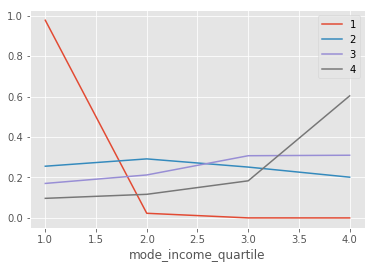

In [11]:
summed_proba_mode_income.loc[[1, 2, 3, 4]].plot()

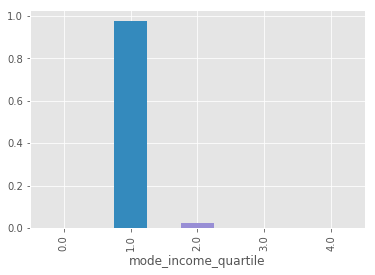

In [12]:
summed_proba_mode_income[1].plot.bar()

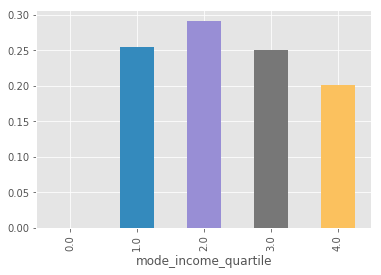

In [13]:
summed_proba_mode_income[2].plot.bar()

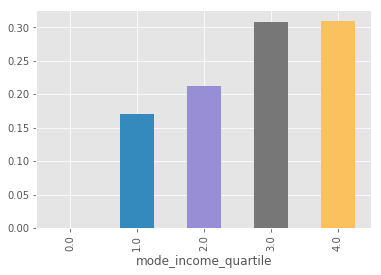

In [14]:
summed_proba_mode_income[3].plot.bar()

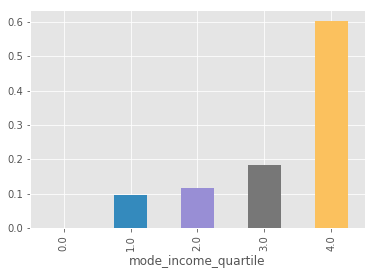

In [15]:
summed_proba_mode_income[4].plot.bar()

## Summed capacity-weighted probabilities by  zonal mode income quartile

In [16]:
def capacity_weighted_proba(w, x, alt_capacity):
    proba = calculate_proba(w, x)
    capacity_weighted_proba = proba * alt_capacity
    sum_capac_wproba_across_submodels = capacity_weighted_proba.sum(axis=1, keepdims=True)
    capacity_weighted_proba_normalized = capacity_weighted_proba / sum_capac_wproba_across_submodels
    
    return capacity_weighted_proba_normalized

In [17]:
##  There really is huge vacant capacity in low income zones

In [18]:
w = get_submodel_coeffs()
capac_weighted_proba = np.transpose(capacity_weighted_proba(w, x, vacant_spaces))

proba_df = pd.DataFrame(capac_weighted_proba, columns=submodel_ids)
proba_df['mode_income_quartile'] = buildings.mode_income_quartile.values

summed_capac_weighted_proba_mode_income = proba_df.groupby('mode_income_quartile').sum()

In [19]:
summed_capac_weighted_proba_mode_income

,1,2,3,4
mode_income_quartile,,,,
0.0000,0.0000,0.0005,0.0001,0.0001
1.0000,0.8778,0.4485,0.3427,0.2999
2.0000,0.1218,0.2713,0.2685,0.1981
3.0000,0.0004,0.1580,0.1921,0.1617
4.0000,0.0000,0.1217,0.1966,0.3401


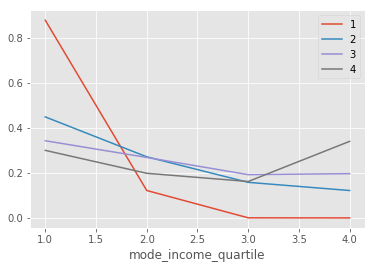

In [20]:
summed_capac_weighted_proba_mode_income.loc[[1, 2, 3, 4]].plot()

In [21]:
## See above..  The large vacancies in poorer areas are driving rich hh there

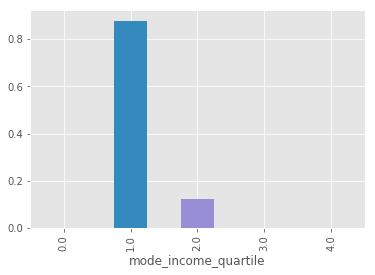

In [22]:
summed_capac_weighted_proba_mode_income[1].plot.bar()

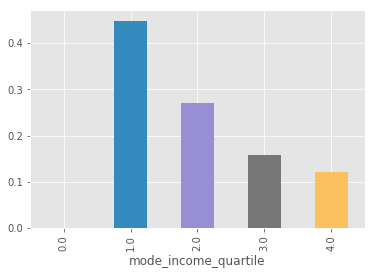

In [23]:
summed_capac_weighted_proba_mode_income[2].plot.bar()

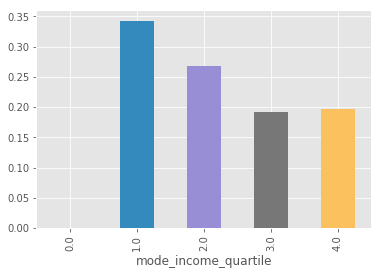

In [24]:
summed_capac_weighted_proba_mode_income[3].plot.bar()

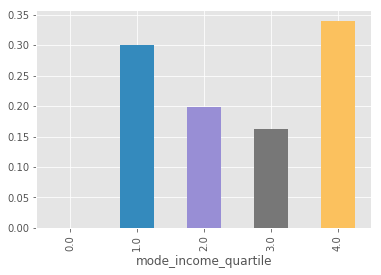

In [25]:
summed_capac_weighted_proba_mode_income[4].plot.bar()

## Expected growth by zonal mode income quartile

In [26]:
idx_mode_1 = buildings.mode_income_quartile_is_1.values
idx_mode_2 = buildings.mode_income_quartile_is_2.values
idx_mode_3 = buildings.mode_income_quartile_is_3.values
idx_mode_4 = buildings.mode_income_quartile_is_4.values

In [27]:
def expected_growth(w, x, alt_capacity, obs_growth):
    capacity_weighted_proba_normalized = capacity_weighted_proba(w, x, alt_capacity)
    expected_growth = np.transpose(capacity_weighted_proba_normalized * obs_growth)
    return expected_growth

In [28]:
w = get_submodel_coeffs()
expected_growths = expected_growth(w, x, vacant_spaces, quartile_changes)

proba_df = pd.DataFrame(expected_growths, columns=submodel_ids)
proba_df['mode_income_quartile'] = buildings.mode_income_quartile.values

expected_growths = proba_df.groupby('mode_income_quartile').sum()

In [30]:
expected_growths

,1,2,3,4
mode_income_quartile,,,,
0.0000,0.0000,36.0162,2.4600,2.6950
1.0000,"63,132.9414","31,718.6924","14,968.6540","7,781.5873"
2.0000,"8,758.3307","19,188.3104","11,729.1668","5,140.0878"
3.0000,29.6911,"11,171.3679","8,390.9767","4,196.1949"
4.0000,0.0368,"8,604.6130","8,584.7426","8,823.4350"


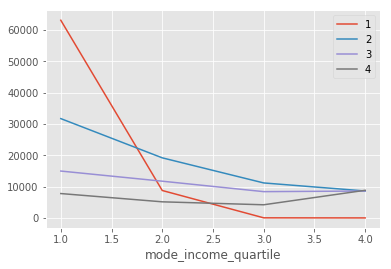

In [31]:
expected_growths.loc[[1, 2, 3, 4]].plot()

## What value of a dummy variable for is-zone-mode-income-1 will help match observed shares of each income quartile in low-income areas

In [32]:
# Objective function to minimize

def growth_share_deviation(coeff, w, x, obs_growth, idx_alts, growth_share_target, submodel_idx, coeff_idx, alt_capacity):
    w[submodel_idx, coeff_idx] = coeff
    expected_growths = expected_growth(w, x, alt_capacity, obs_growth)
    
    proba_df = pd.DataFrame(expected_growths, columns=submodel_ids)
    proba_df['mode_income_quartile'] = buildings.mode_income_quartile.values
    growth_totals = proba_df.groupby('mode_income_quartile').sum()

    alts_of_interest = expected_growths[np.where(idx_alts)]
    growth_shares_by_submodel = alts_of_interest.sum(axis=0) / expected_growths.sum(axis=0)
    abs_deviation = abs(growth_shares_by_submodel[submodel_idx] - growth_share_target)
    return abs_deviation

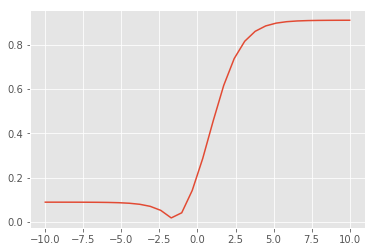

In [37]:
w = get_submodel_coeffs()

coeffs = np.linspace(-10, 10, 30)
errors = [growth_share_deviation(coeff, w, x, quartile_changes, idx_mode_1, .09, 3, 18, vacant_spaces) for coeff in coeffs]
plt.plot(coeffs, errors)

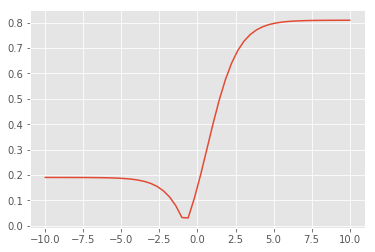

In [38]:
w = get_submodel_coeffs()

coeffs = np.linspace(-10, 10, 50)
errors = [growth_share_deviation(coeff, w, x, quartile_changes, idx_mode_1, .19, 2, 18, vacant_spaces) for coeff in coeffs]
plt.plot(coeffs, errors)

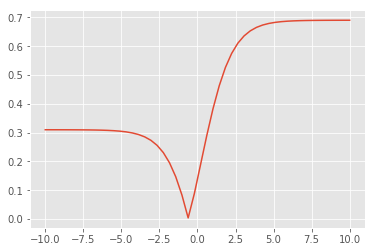

In [39]:
w = get_submodel_coeffs()

coeffs = np.linspace(-10, 10, 50)
errors = [growth_share_deviation(coeff, w, x, quartile_changes, idx_mode_1, .31, 1, 18, vacant_spaces) for coeff in coeffs]
plt.plot(coeffs, errors)

## Calibrating an is_income_mode_1 dummy

In [40]:
result = opt.minimize_scalar(growth_share_deviation, method='Brent', args=(w, x, quartile_changes, idx_mode_1, .09, 3, 18, vacant_spaces))
print result.x

-1.4660410480292232


In [41]:
result = opt.minimize_scalar(growth_share_deviation, method='Brent', args=(w, x, quartile_changes, idx_mode_1, .19, 2, 18, vacant_spaces))
print result.x

-0.798815413818028


In [42]:
result = opt.minimize_scalar(growth_share_deviation, method='Brent', args=(w, x, quartile_changes, idx_mode_1, .31, 1, 18, vacant_spaces))
print result.x

-0.593455940199034
